In [80]:
# imports 
import numpy as np
import os, sys
import monai
from monai.data import CacheDataset, DataLoader, GridPatchDataset
from monai.transforms import (
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    LoadImaged,
    Resized,
    ScaleIntensityd,
    SqueezeDimd,
    MapLabelValued,
    LoadImage,
    Rotated,
    Flipd,
    SpatialPadd,
    SpatialResampled,
)

from monai.networks.nets import UNet

import math
import matplotlib.pyplot as plt
import glob
import torch
import SimpleITK as sitk

ImportError: cannot import name 'Resampled' from 'monai.transforms' (/home/aeijpe/.conda/envs/gpu_env/lib/python3.11/site-packages/monai/transforms/__init__.py)

In [2]:
import sys
sys.path.insert(0, '..')
from transforms import CropAroundMaskd

In [154]:
data_dir = "../../MMWHS_Dataset/mr_train"
images = sorted(glob.glob(os.path.join(data_dir, "mr_train_1001_image.nii.gz")))
labels = sorted(glob.glob(os.path.join(data_dir, "mr_train_1001_label.nii.gz")))

example_dataset = [{"img": img, "seg": seg} for img, seg in zip(images, labels)]
print(len(example_dataset))
case = 1001

1


In [138]:
loaded_img = LoadImaged(keys=['img', 'seg'], image_only=False)(example_dataset[0])

In [141]:
print(loaded_img["img_meta_dict"])

{'sizeof_hdr': array(348, dtype=int32), 'extents': array(0, dtype=int32), 'session_error': array(0, dtype=int16), 'dim_info': array(16, dtype=uint8), 'dim': array([  3, 512, 512, 160,   1,   1,   1,   1], dtype=int16), 'intent_p1': array(0., dtype=float32), 'intent_p2': array(0., dtype=float32), 'intent_p3': array(0., dtype=float32), 'intent_code': array(0, dtype=int16), 'datatype': array(4, dtype=int16), 'bitpix': array(16, dtype=int16), 'slice_start': array(0, dtype=int16), 'pixdim': array([-1.        ,  0.78125   ,  0.78125   ,  1.6       ,  0.28585002,
        0.        ,  0.        ,  0.        ], dtype=float32), 'vox_offset': array(0., dtype=float32), 'scl_slope': array(nan, dtype=float32), 'scl_inter': array(nan, dtype=float32), 'slice_end': array(0, dtype=int16), 'slice_code': array(0, dtype=uint8), 'xyzt_units': array(10, dtype=uint8), 'cal_max': array(0., dtype=float32), 'cal_min': array(0., dtype=float32), 'slice_duration': array(3.07e-43, dtype=float32), 'toffset': array(0.

In [164]:
print(loaded_img["seg_meta_dict"])

{'sizeof_hdr': array(348, dtype=int32), 'extents': array(0, dtype=int32), 'session_error': array(0, dtype=int16), 'dim_info': array(16, dtype=uint8), 'dim': array([  3, 512, 512, 160,   1,   1,   1,   1], dtype=int16), 'intent_p1': array(0., dtype=float32), 'intent_p2': array(0., dtype=float32), 'intent_p3': array(0., dtype=float32), 'intent_code': array(0, dtype=int16), 'datatype': array(512, dtype=int16), 'bitpix': array(16, dtype=int16), 'slice_start': array(0, dtype=int16), 'pixdim': array([-1.     ,  0.78125,  0.78125,  1.6    ,  1.     ,  0.     ,
        0.     ,  0.     ], dtype=float32), 'vox_offset': array(0., dtype=float32), 'scl_slope': array(nan, dtype=float32), 'scl_inter': array(nan, dtype=float32), 'slice_end': array(0, dtype=int16), 'slice_code': array(0, dtype=uint8), 'xyzt_units': array(10, dtype=uint8), 'cal_max': array(0., dtype=float32), 'cal_min': array(0., dtype=float32), 'slice_duration': array(1.26e-43, dtype=float32), 'toffset': array(0., dtype=float32), 'glm

In [155]:
volume_transforms = Compose(
        [
            LoadImaged(keys=["img", "seg"]),
            EnsureChannelFirstd(keys=["img", "seg"]),
            ScaleIntensityd(keys="img"), # normalization between 0 and 1 # segmentation masl also?
            EnsureTyped(keys=["img", "seg"]),
            Resized(keys=["img"], spatial_size=(160, 160, 160), mode = 'bilinear'), 
            Resized(keys=["seg"], spatial_size=(160, 160, 160), mode = 'nearest'),
             # resample to 1mm spacing with isotropic voxel size
            #CropAroundMaskd(keys=["img", "seg"], spatial_size = 256),
        ])  

In [147]:
volume_ds_person1 = CacheDataset(data=example_dataset, transform=volume_transforms, cache_rate=1.0, num_workers=4) # experiment with last two parameters
check_loader = DataLoader(volume_ds_person1, batch_size=1)
check_data = monai.utils.misc.first(check_loader)

Loading dataset: 100%|██████████| 1/1 [00:06<00:00,  6.00s/it]


In [156]:
print("first volume's shape", check_data["img"].shape, check_data["seg"].shape)
spat_size = check_data["img"].shape[3]
print("spatial size", spat_size)


first volume's shape torch.Size([1, 1, 160, 160, 160]) torch.Size([1, 1, 160, 160, 160])
spatial size 160


In [161]:
patch_func = monai.data.PatchIterd(
    keys=["img", "seg"],
    patch_size=(None, 1, None),  # dynamic first two dimensions (None, 1, None)
    start_pos=(0, 0, 0)
)
patch_transform = Compose(
        [
        #     Resized(keys=["img"], spatial_size=[256,1,256], mode = "bilinear"),# size_mode="all"),
        #     Resized(keys=["seg"], spatial_size=[256,1,256], mode = "nearest"),
            MapLabelValued(keys=["seg"], orig_labels=[205, 420, 500, 550, 600, 820, 850], target_labels=[1, 2, 3, 4, 5 , 6 , 7]),
            #SpatialPadd(keys=["img", "seg"], spatial_size=[256, 1, 256]),#, mode="zeros"),
            SqueezeDimd(keys=["img", "seg"], dim=0),  # squeeze the first dim
        ]
    )

filenames = [f"{case}_slice_orig.nii.gz", f"{case}_slice_resized.nii.gz", f"{case}_slice_cropped_resize.nii.gz"]
filename = filenames[1]
filename = f"{case}_slice_resized2.nii.gz"

example_patch_ds = GridPatchDataset(data=volume_ds_person1, patch_iter=patch_func, transform=patch_transform)
patch_data_loader = DataLoader(example_patch_ds, batch_size=1, num_workers=2, pin_memory=torch.cuda.is_available())


In [162]:
i = 1
current_directory = os.getcwd()
output_dir_image = "../preprocessed/mr_examples/images"
output_dir_label = "../preprocessed/mr_examples/labels"

os.makedirs(output_dir_image, exist_ok=True)
os.makedirs(output_dir_label, exist_ok=True)

j=0
for batch in patch_data_loader:
    image, label = batch[0]["img"], batch[0]["seg"]
    j += 1
    if j > 80: #spat_size/2
        image = image.squeeze(2)
        label = label.squeeze(2)
        print("image shape", image.shape, "label shape", label.shape)

        # Convert the torch tensor to a SimpleITK image
        slice_image = sitk.GetImageFromArray(image)
        slice_label = sitk.GetImageFromArray(label)
        # # Save the 2D slice as a NIfTI file
        print(output_dir_image, filename)
        sitk.WriteImage(slice_image, os.path.join(output_dir_image, filename))
        sitk.WriteImage(slice_label, os.path.join(output_dir_label, filename))
        i += 1
        break

print("Total number of slices:", i)

image shape torch.Size([1, 160, 160]) label shape torch.Size([1, 160, 160])
../preprocessed/mr_examples/images 1001_slice_resized2.nii.gz
Total number of slices: 2


image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


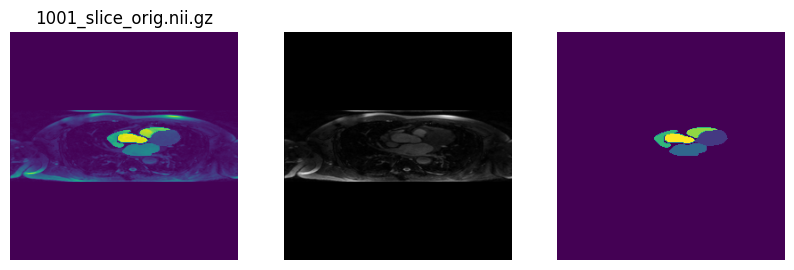

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


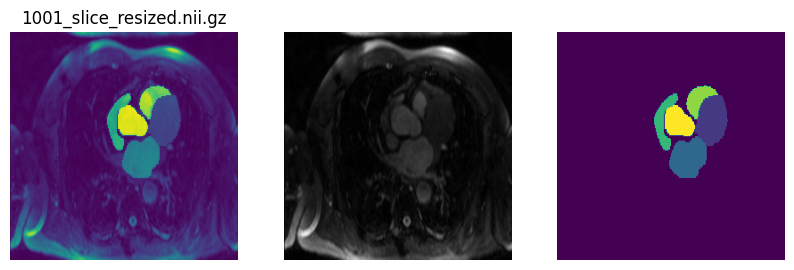

image data shape: torch.Size([160, 160, 1])
label data shape: torch.Size([160, 160, 1])


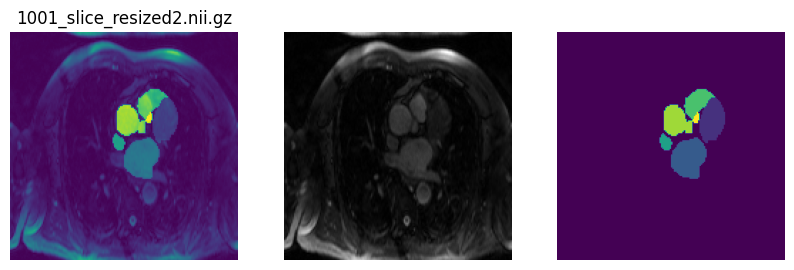

In [163]:
case = 1001
filenames = [f"{case}_slice_orig.nii.gz", f"{case}_slice_resized.nii.gz", f"{case}_slice_resized2.nii.gz"]

for name in filenames:
    file_original = f"../preprocessed/mr_examples/images/{name}"
    example_im_original = LoadImage(image_only=True, simple_keys=True)(file_original)
    print(f"image data shape: {example_im_original.shape}")

    label_original = f"../preprocessed/mr_examples/labels/{name}"
    example_label_original = LoadImage(image_only=True, simple_keys=True)(label_original)
    print(f"label data shape: {example_label_original.shape}")

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title(f"{name}")
    plt.axis("off")
    plt.imshow((example_im_original + example_label_original/10) / 2)
    plt.subplot(1, 3, 2)
    plt.axis("off")
    plt.imshow(example_im_original, cmap="gray")
    plt.subplot(1, 3, 3)
    plt.axis("off")
    plt.imshow(example_label_original)
    plt.show()

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


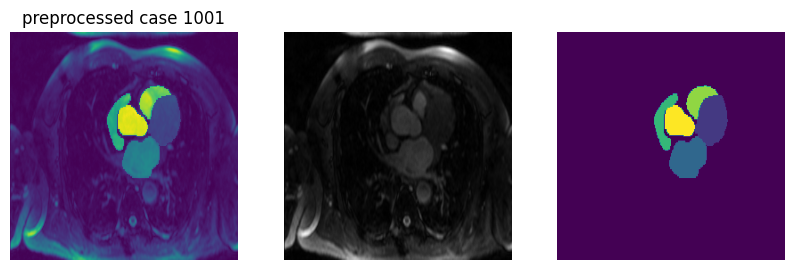

FileNotFoundError: No such file or no access: '../preprocessed/mr_examples/images/1002_slice_resized.nii.gz'

In [101]:
# original, mapped, flipped, resized
for case in range(1001, 1021):
    file_original = f"../preprocessed/mr_examples/images/{case}_slice_resized.nii.gz"
    example_im_original = LoadImage(image_only=True, simple_keys=True)(file_original)
    print(f"image data shape: {example_im_original.shape}")

    label_original = f"../preprocessed/mr_examples/labels/{case}_slice_resized.nii.gz"
    example_label_original = LoadImage(image_only=True, simple_keys=True)(label_original)
    print(f"label data shape: {example_label_original.shape}")

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title(f"preprocessed case {case}")
    plt.axis("off")
    plt.imshow((example_im_original + example_label_original/10) / 2)
    plt.subplot(1, 3, 2)
    plt.axis("off")
    plt.imshow(example_im_original, cmap="gray")
    plt.subplot(1, 3, 3)
    plt.axis("off")
    plt.imshow(example_label_original)
    plt.show()

In [ ]:
d

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


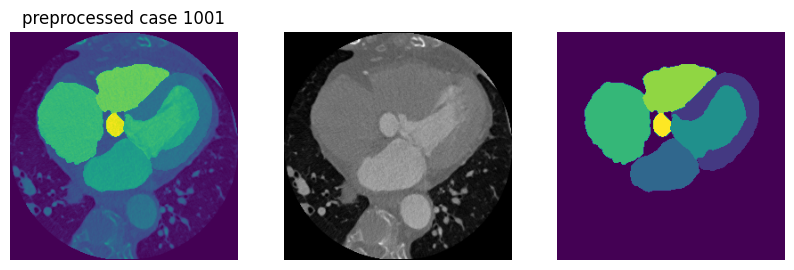

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


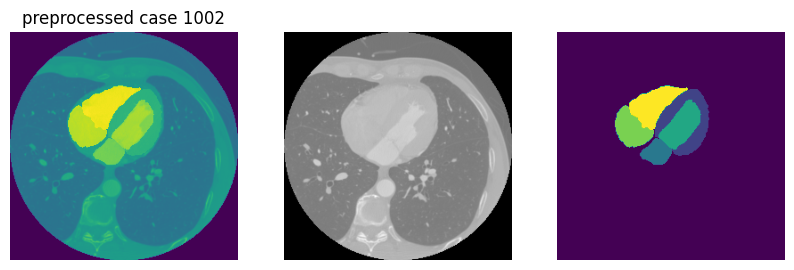

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


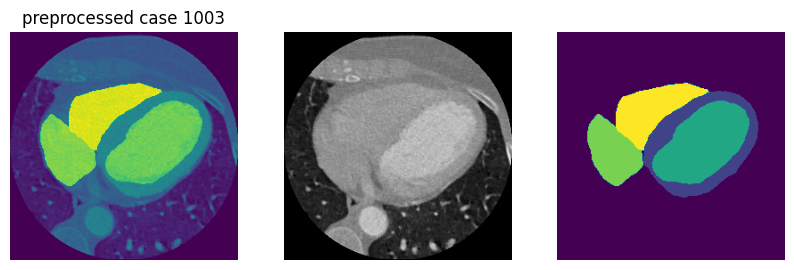

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


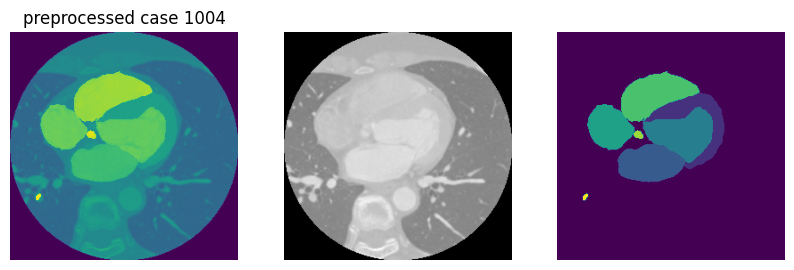

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


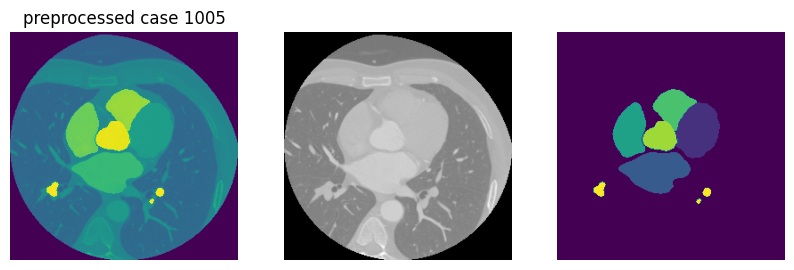

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


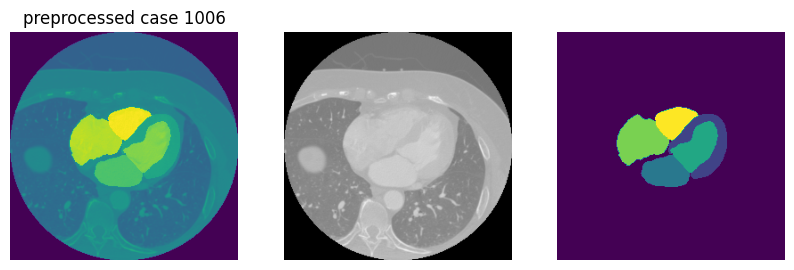

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


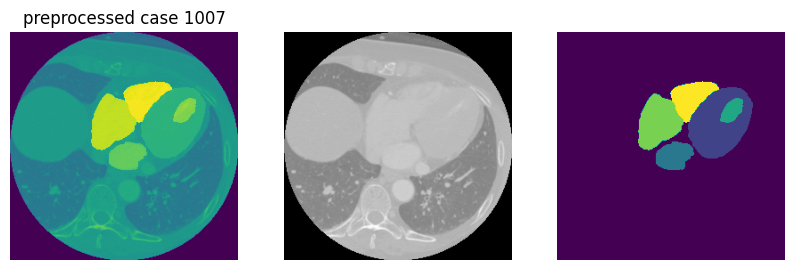

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


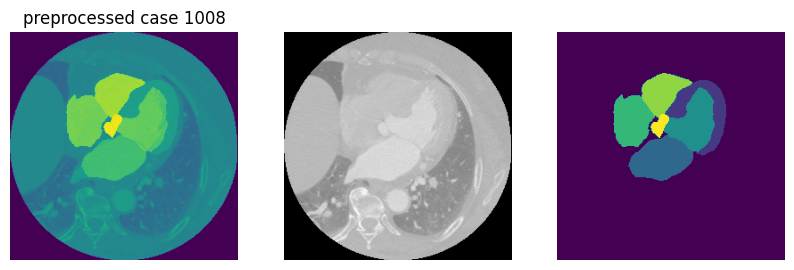

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


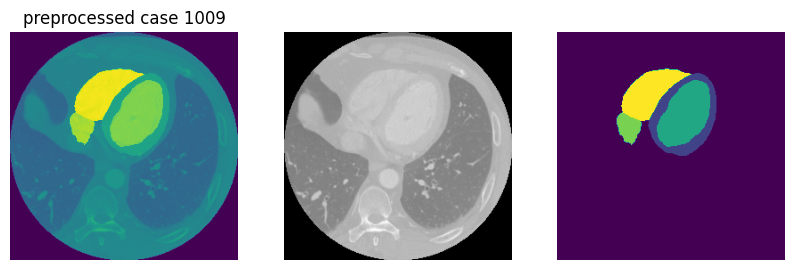

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


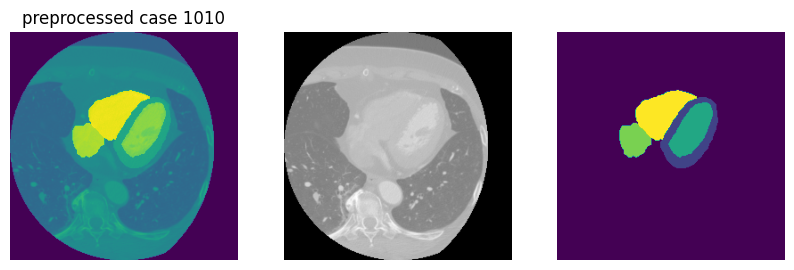

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


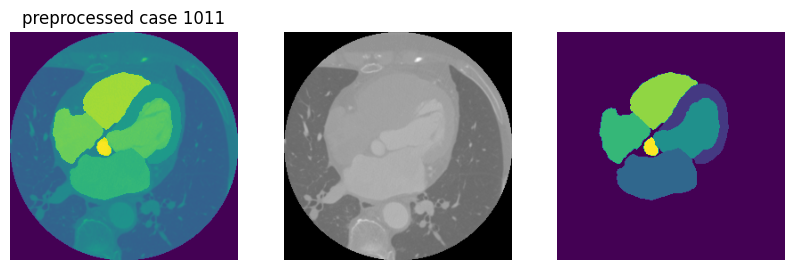

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


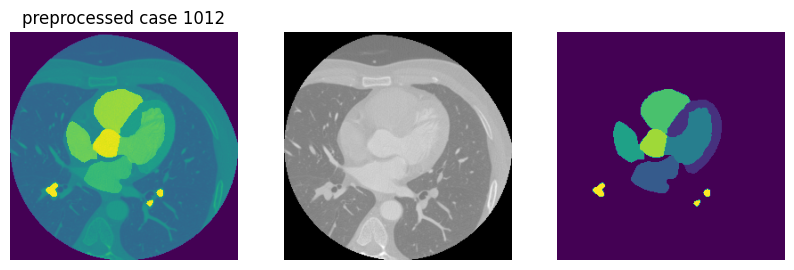

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


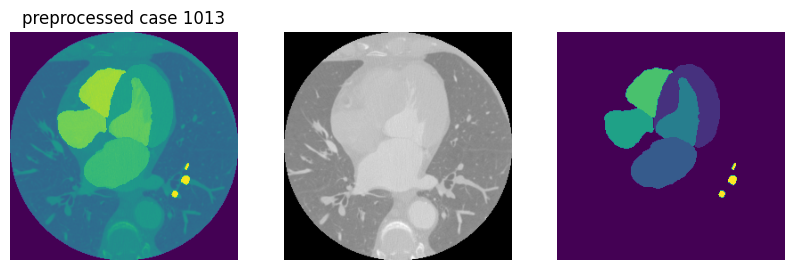

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


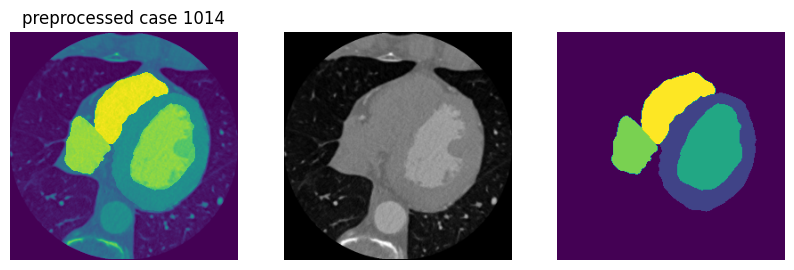

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


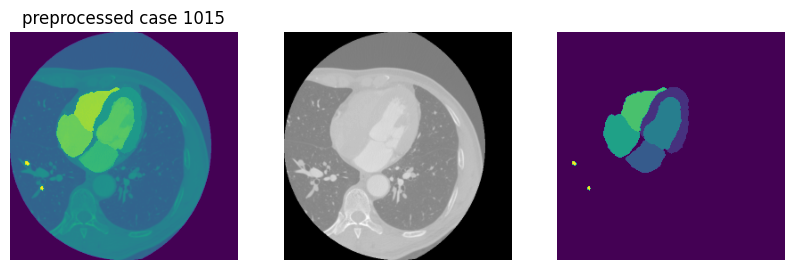

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


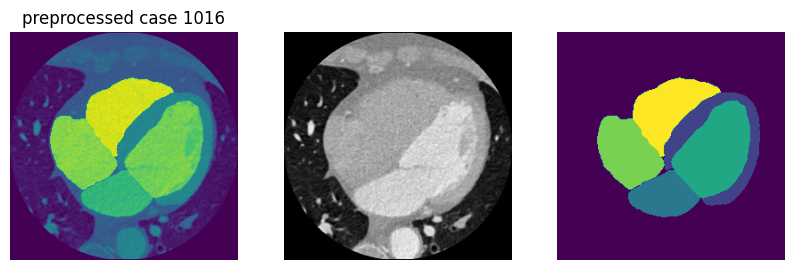

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


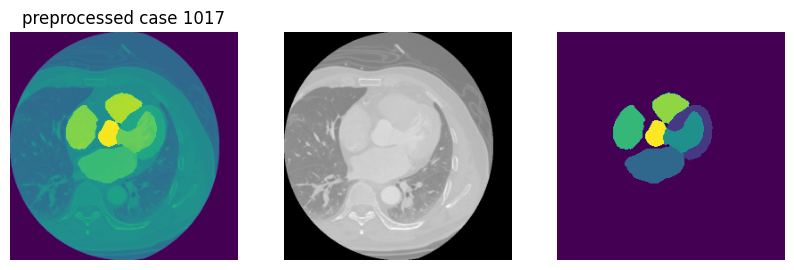

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


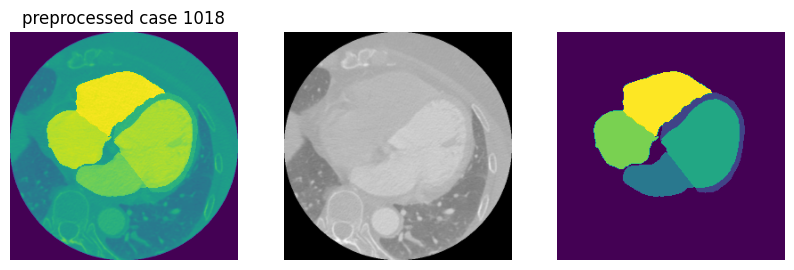

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


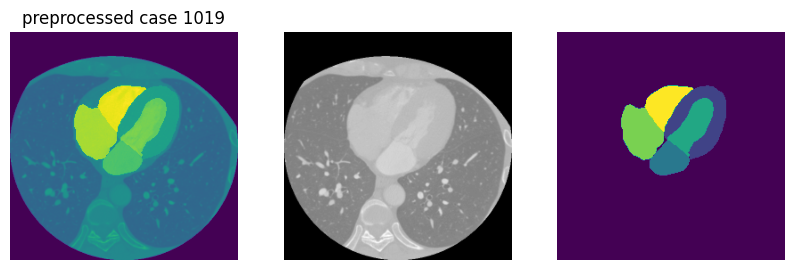

image data shape: torch.Size([256, 256, 1])
label data shape: torch.Size([256, 256, 1])


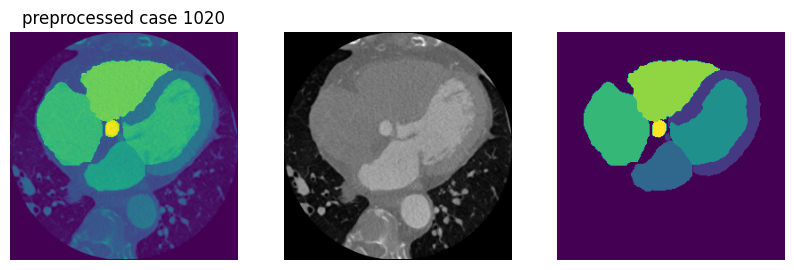

In [44]:
# original, mapped, flipped, resized
for case in range(1001, 1021):
    file_original = f"../preprocessed/ct_examples/images/{case}_slice_orig_map_flip_resize.nii.gz"
    example_im_original = LoadImage(image_only=True, simple_keys=True)(file_original)
    print(f"image data shape: {example_im_original.shape}")

    label_original = f"../preprocessed/ct_examples/labels/{case}_slice_orig_map_flip_resize.nii.gz"
    example_label_original = LoadImage(image_only=True, simple_keys=True)(label_original)
    print(f"label data shape: {example_label_original.shape}")

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title(f"preprocessed case {case}")
    plt.axis("off")
    plt.imshow((example_im_original + example_label_original/10) / 2)
    plt.subplot(1, 3, 2)
    plt.axis("off")
    plt.imshow(example_im_original, cmap="gray")
    plt.subplot(1, 3, 3)
    plt.axis("off")
    plt.imshow(example_label_original)
    plt.show()

In [ ]:
# original
file_original = f"../preprocessed/ct_examples/images/{case}_slice_orig.nii.gz"
example_im_original = LoadImage(image_only=True, simple_keys=True)(file_original)
print(f"image data shape: {example_im_original.shape}")

label_original = f"../preprocessed/ct_examples/labels/{case}_slice_orig.nii.gz"
example_label_original = LoadImage(image_only=True, simple_keys=True)(label_original)
print(f"label data shape: {example_label_original.shape}")

# transformed
file_original_map = f"../preprocessed/ct_examples/images/{case}_slice_cropped.nii.gz"
example_im_original_map = LoadImage(image_only=True, simple_keys=True)(file_original_map)
print(f"image data shape: {example_im_original_map.shape}")

label_original_map = f"../preprocessed/ct_examples/labels/{case}_slice_cropped.nii.gz"
example_label_original_map = LoadImage(image_only=True, simple_keys=True)(label_original_map)
print(f"label data shape: {example_label_original_map.shape}")

# transformed and resized
file_original_map_flip = f"../preprocessed/ct_examples/images/{case}_slice_cropped_resize.nii.gz"
example_im_original_map_flip = LoadImage(image_only=True, simple_keys=True)(file_original_map_flip)
print(f"image data shape: {example_im_original_map_flip.shape}")

label_original_map_flip = f"../preprocessed/ct_examples/labels/{case}_slice_cropped_resize.nii.gz"
example_label_original_map_flip = LoadImage(image_only=True, simple_keys=True)(label_original_map_flip)
print(f"label data shape: {example_label_original_map_flip.shape}")


In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(3, 3, 1)
plt.title("original")
plt.axis("off")
plt.imshow((example_im_original + example_label_original/1000) / 2)
plt.subplot(3, 3, 2)
plt.axis("off")
plt.imshow(example_im_original, cmap="gray")
plt.subplot(3, 3, 3)
plt.axis("off")
plt.imshow(example_label_original)

plt.subplot(3, 3, 4)
plt.title("transform")
plt.axis("off")
plt.imshow((example_im_original_map + example_label_original_map/10) / 2)
plt.subplot(3, 3, 5)
plt.axis("off")
plt.imshow(example_im_original_map, cmap="gray")
plt.subplot(3, 3, 6)
plt.axis("off")
plt.imshow(example_label_original_map)

plt.subplot(3, 3, 7)
plt.title("transform+resize")
plt.axis("off")
plt.imshow((example_im_original_map_flip + example_label_original_map_flip/10) / 2)
plt.subplot(3, 3, 8)
plt.axis("off")
plt.imshow(example_im_original_map_flip, cmap="gray")
plt.subplot(3, 3, 9)
plt.axis("off")
plt.imshow(example_label_original_map_flip)


plt.tight_layout()